based on https://blog.floydhub.com/gru-with-pytorch/

In [1]:
import pandas as pd
from typing import List, Tuple, Union, Set
import numpy as np
import time
import os

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
print("sns-version: ", sns.__version__)

# there are issues when using sns scatterplot (replot) with matplotlib version 3.3.1, so we have to check if it is actual
print("matplotlib-version: ", matplotlib.__version__)


sns-version:  0.11.1
matplotlib-version:  3.3.1


In [2]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Is Cuda installed: ", is_cuda)

Is Cuda installed:  True


In [3]:
trainingset_folder = "D:/data_mt/09_training/"
stock_data_folder = trainingset_folder + "stocks/"
stock_potential_folder = trainingset_folder + "stocks_w_potential/"
gru_model_folder = "D:/data_mt/10_models/gru_model/"

## 00_Tools

In [4]:
# load Fundamental Data
def load_reports(tickers: List[str]):
    df = pd.read_csv(trainingset_folder + "company_reports.csv", header=0)
    df.period = pd.to_datetime(df.period)
    df.filed = pd.to_datetime(df.filed)
    
    
    df['i_date'] = df.filed
    df.set_index('i_date', inplace = True)
    df.sort_index(inplace = True)

    return df[df.ticker.isin(tickers)]

In [5]:
def load_stock_history(ticker: str):
    df = pd.read_csv(stock_potential_folder + ticker[0] + "/" + ticker + ".csv")
    df.Date = pd.to_datetime(df.Date)
    
    df = df[df.Date > "2012-01-01"]
    df['i_date'] = df.Date
    df.set_index('i_date', inplace=True)
    df.sort_index(inplace = True)
        
    return df

In [6]:
def load_additional_info() -> pd.DataFrame:
    return pd.read_csv(trainingset_folder + "company_info.csv", sep=',', encoding='utf-8', header=0)

## 01_Basics

In [7]:
features_reports = [
            'r_workcapToAssets', 'r_currentRatio', 'r_deptToEquity', 'r_deptRatio', 'r_netProfitMargin',
            'r_operatingMargin', 'r_netIncomeMargin', 'r_cashGenPowerRatio', 'r_extFinancingIndexRatio',
            'r_returnOnEquity', 'r_returnOnAssets', 'r_assetsTurnoverRatio', 'r_dividendPayoutRatio', 
            'r_stockRepurchaseRatio', 'r_operatingCashFlowRatio', 'r_assetEfficiencyRatio', 
            'r_currentLiabCoverageRatio', 'r_longtermDeptCoverageRatio',
            
            # 'gr_revenue_n', 'gr_asscur_n', 'gr_assnoncur_n','gr_liabcur_n', 'gr_liabnoncur_n',
            
            'gr_revenue_p', 'gr_grosspr_n', 'gr_grosspr_p', 'gr_opiincome_n', 'gr_opiincome_p', 
            'gr_netincome_n', 'gr_netincome_p', 
            'gr_earnings_n', 'gr_earnings_p', 'gr_equity_n', 'gr_equity_p', 
            'gr_asscur_p', 'gr_assnoncur_p', 'gr_liabcur_p',
            'gr_liabnoncur_p', 'gr_cashfrominv_n', 'gr_cashfrominv_p', 
            'gr_cashfromfin_n', 'gr_cashfromfin_p', 'gr_cashfromope_n', 'gr_cashfromope_p', 
            'gr_dividends_n', 'gr_dividends_p',

            'fp__FY', 'fp__Q1', 'fp__Q2', 'fp__Q3', 'fp__Q4', ]

features_stockdata = [
            'high_norm', 'low_norm', 'open_norm', 'volume_norm', 'close_chg',
            # 'volume_chg',remove -> inf values and much larger than 1
            'day_of_week', 'day_of_month', 'day_of_year', 'week_of_year', 'month_of_year',
            'pr_p2e_norm', 'pr_p2b_norm', 'pr_p2egr_1y_norm'
            ]

features_add_info = [
            'sec__BasicMaterials', 'sec__CommunicationServices', 'sec__ConsumerCyclical', 'sec__ConsumerDefensive',
            'sec__Energy', 'sec__FinancialServices', 'sec__Healthcare',  'sec__IndustrialGoods', 'sec__Industrials',
            'sec__RealEstate', 'sec__Technology', 'sec__Utilities',
            
            'ind__AerospaceDefense', 'ind__ApparelRetail', 'ind__AssetManagement', 'ind__AutoParts', 'ind__BanksRegional',
            'ind__Biotechnology', 'ind__CommunicationEquipment', 'ind__CreditServices', 'ind__DiagnosticsResearch',
            'ind__ElectronicComponents', 'ind__InformationTechnologyServices', 'ind__InsurancePropertyCasualty',
            'ind__MedicalDevices', 'ind__MedicalInstrumentsSupplies', 'ind__OilGasEP', 'ind__OilGasEquipmentServices',
            'ind__OilGasMidstream', 'ind__Other', 'ind__PackagedFoods', 'ind__Restaurants', 
            'ind__ScientificTechnicalInstruments', 'ind__SemiconductorEquipmentMaterials', 'ind__Semiconductors',
            'ind__SoftwareApplication', 'ind__SoftwareInfrastructure', 'ind__SpecialtyBusinessServices',
            'ind__SpecialtyChemicals', 'ind__SpecialtyIndustrialMachinery', 'ind__SpecialtyRetail',

            'mc_top10', 'mc_top20', 'mc_top30', 'mc_top50','mc_top100','mc_top200']

tabular_features = list(features_stockdata)
tabular_features.extend(features_add_info)

label = 'r_potential'

In [8]:
add_info = load_additional_info()

In [9]:
tickers_to_process_test = ['AAPL', 'MSFT']
tickers_to_process_100 = add_info[add_info.mc_top100 == 1.0].ticker.unique()

In [10]:
tickers_to_process_all = add_info[add_info.mc_top500 == 1.0].ticker.unique()
len(tickers_to_process_all)

497

In [11]:
# laod all reports
reports_df = load_reports(tickers_to_process_all)
reports_df.shape

(16542, 85)

## 02_Preparation

### Scalers

In [12]:
reports_features_scaler = MinMaxScaler()
reports_features_scaler.fit(reports_df[features_reports])

stock_features_scaler = MinMaxScaler()

labels_scaler = MinMaxScaler()

## 03_build dataset
Prepare the train and testdata.<br>
Out of the financial data from the reports sequences of reports are created and then matched based on the filed date of the latest report in the sequence. This one will be refered to as "series_x" in the code. <br>
Furthermore, the features of the historical stockdata are combined with the data read from the "add_info". These will be refered as "features_x".<br>
So for every day that there are 61 'tabular' features (historical stockdata and add_info) and a sequence of data from 8 reports with 46 features.

### Helper functions

In [13]:
import joblib

def save_scaler(scaler, filename):
    joblib.dump(scaler, filename) 
    
def load_scaler(filename):
    return joblib.load(filename) 

In [14]:
def create_sequence_series(reports_ticker_df: pd.DataFrame, sequence_length:int) -> pd.Series:
    """
    creates the timeseries arrays based on the features in the provided dataframe.
    returns them as a pandas series, so that they can be merged with other data
    """
    nr_of_report_features = len(features_reports)
    
    # scale the data, float32 should be enough
    np_feature_rows = reports_features_scaler.transform(reports_ticker_df[features_reports]).astype(np.float32)
    
    nr_of_rows      = np_feature_rows.shape[0]
    nr_of_sequences = nr_of_rows - sequence_length + 1 # example: if there are 8 rows and the sequence_length size is 8, we can create 1 timeseries arr

    # create empty array to hold the data
    feature_seq_arr = np.zeros((nr_of_sequences, sequence_length, nr_of_report_features))
    
    # create the timeseries (sequences) arrays
    for i in range(0, nr_of_sequences):
        feature_seq_arr[i] = np_feature_rows[i : i + sequence_length]
    
    # convert into pandas series, there might be a more efficient way, but it works
    flat_input = feature_seq_arr.reshape(-1, sequence_length * nr_of_report_features)    
    pd_features_col = pd.Series(flat_input.tolist(), name='features')\
                        .apply(lambda field: np.array(field).reshape(sequence_length, nr_of_report_features))

    return pd_features_col

In [15]:
# these features havet to be passed on so that the "price_ratio_features" can be calculated
features_to_forward = ['filed', 'c_NetIncomeLoss', 'c_PaymentsOfDividendsTotal', 'Assets', 'Liabilities', 'gr_netincome_p']

def attach_sequence_series_col_to_report_data(reports_ticker_df: pd.DataFrame, pd_features_col: pd.Series, sequence_length: int) -> pd.DataFrame:
    """
       reports_ticker_df contains all reports for one ticker.
       pd_features_col contains the prepared numpy sequence arrays which have were created based on the reports_ticker_df.
       now we are going to attach that col back to the reports_ticker_df, so that we can merge it more easily with the daily stock data
    """
    # only select those rows, which are needed for the further processing, drop index, so that the feature col can be added
    reports_ticker_merge_df = reports_ticker_df[sequence_length - 1:][features_to_forward].reset_index(drop=True)
    
    df_combined = pd.concat([reports_ticker_merge_df, pd_features_col], axis=1)
    df_combined['i_date'] = df_combined.filed
    df_combined.set_index('i_date', inplace=True)
    
    return df_combined

In [16]:
def merge_stock_data_with_report_data(pd_reports_ready_ticker_df: pd.DataFrame, stock_data_ticker_df: pd.DataFrame) -> pd.DataFrame:
    """ There is only one report every three months, but we do have daily stock prices so wie have to merge them, resp. fill the gaps.
        In order to do that, we have to use the 'filed' date, since this is the date the report was published.
    """
  
    df_with_stock = pd.merge(pd_reports_ready_ticker_df, stock_data_ticker_df, left_index=True, right_index=True, how='outer')
    df_with_stock.sort_index(inplace=True)
    
    
    # ffill sollte eigentlich nur auf den report daten erfolgen.. 
    df_with_stock = df_with_stock.fillna(method="ffill") # fill the gaps
    
    # filed is empty vor the dates before the filed date of the first report
    # Date can be empty if the report was filed on a weekend or on a bank holiday.
    
    df_with_stock = df_with_stock.dropna(subset=['filed', 'Date']) 
    return df_with_stock

In [17]:
def create_price_ratio_features_in_place(pd_stock_and_reports_ticker_df: pd.DataFrame, shares_outstanding:int):
    """Calculates stock price depending features. 
    """
    
    pd_stock_and_reports_ticker_df['pr_p2e'] = pd_stock_and_reports_ticker_df.Close * shares_outstanding / (
            pd_stock_and_reports_ticker_df.c_NetIncomeLoss - pd_stock_and_reports_ticker_df.c_PaymentsOfDividendsTotal)
    
    pd_stock_and_reports_ticker_df['pr_p2b'] = pd_stock_and_reports_ticker_df.Close * shares_outstanding / (
            pd_stock_and_reports_ticker_df.Assets - pd_stock_and_reports_ticker_df.Liabilities)
    
    pd_stock_and_reports_ticker_df['pr_p2egr_1y'] = pd_stock_and_reports_ticker_df.pr_p2e / (
            pd_stock_and_reports_ticker_df.gr_netincome_p * 100)  # approximated / denominator in percent

    # caping p2e: in order to prevent meaningless values, we need to restrict the range. The max value is limited to 100.
    # if new_df.c_NetIncomeLoss - new_df.c_PaymentsOfDividendsTotal results in a negativ value, we set p2e to 100, which is rather a "bad" value.
    pd_stock_and_reports_ticker_df.loc[(pd_stock_and_reports_ticker_df.pr_p2e < 0) | (pd_stock_and_reports_ticker_df.pr_p2e > 100), 'pr_p2e'] = 100
    
    # caping p2egr: the lower the better. generally you would like to see a ratio lower than 1, so a 5 can be considered a really bad value so we restrict it to 5
    # if growth number is 0 or less, we set p2egr to 5
    pd_stock_and_reports_ticker_df.loc[(pd_stock_and_reports_ticker_df.pr_p2egr_1y > 5) | (pd_stock_and_reports_ticker_df.pr_p2egr_1y <= 0.0), 'pr_p2egr_1y'] = 5
    
    # normalize
    pd_stock_and_reports_ticker_df['pr_p2e_norm'] = pd_stock_and_reports_ticker_df['pr_p2e'] / 100  # 100 is the max as defined above
    pd_stock_and_reports_ticker_df['pr_p2b_norm'] = pd_stock_and_reports_ticker_df['pr_p2b'] / 100  # p2b of 100 is pretty extreme, values above are very rare
    pd_stock_and_reports_ticker_df['pr_p2egr_1y_norm'] = pd_stock_and_reports_ticker_df['pr_p2egr_1y'] / 5  # 5 is max as defined above

In [18]:
def combine_data_for_ticker(ticker: str, sequence_length: int) -> pd.DataFrame:
    """
        combine the data from the report, the daily stock prices and the additional company info into one DataFrame per ticker.
    """
    
    add_info_ticker    = add_info[add_info.ticker == ticker]
    reports_ticker_df  = reports_df[reports_df.ticker == ticker]
    stock_data_df      = load_stock_history(ticker)
      
    pd_features_ticker_col = create_sequence_series(reports_ticker_df, sequence_length)
    pd_combined_df         = attach_sequence_series_col_to_report_data(reports_ticker_df, pd_features_ticker_col, sequence_length)
    pd_with_stock_df       = merge_stock_data_with_report_data(pd_combined_df, stock_data_df)
    
    shares_outstanding = add_info_ticker.sharesOutstanding.to_list()[0]
    create_price_ratio_features_in_place(pd_with_stock_df, shares_outstanding)
    
    pd_complete_df     = pd.merge(pd_with_stock_df, add_info_ticker, how="outer", on="ticker")
    
    return pd_complete_df

In [19]:
def add_test_train_values(series_x, features_x, y, pd_ticker: pd.DataFrame, sequence_length: int):
    
    nr_of_report_features = len(features_reports)
    
    arr_of_arr_of_series_features = pd_ticker.features.to_numpy()
    series_x_ticker = np.concatenate(arr_of_arr_of_series_features) \
                              .reshape(arr_of_arr_of_series_features.shape[0], sequence_length, nr_of_report_features)

    features_x_ticker = pd_ticker[tabular_features].to_numpy()

    y_ticker = pd_ticker.r_potential.to_numpy()

    if len(y) == 0:
        series_x   = series_x_ticker
        features_x = features_x_ticker
        y          = y_ticker
    else:
        series_x   = np.concatenate((series_x, series_x_ticker))
        features_x = np.concatenate((features_x, features_x_ticker))
        y          = np.concatenate((y, y_ticker))
    
    return series_x, features_x, y   

In [20]:
def build_train_testset(tickers: List[str], sequence_length: int):
    """ creating the numpy arrays for training and testing. 
      
        the data is divided in three parts:
        - the numpy array with the sequence series
        - the numpy array with the stock features
        - the numpy array with the labels
    """
    
    train_series_x   = [] # timeseries features
    train_features_x = [] # tabular features
    train_y          = [] # target label
    
    test_series_x    = []
    test_features_x  = []
    test_y           = []
    test_pd_list     = []
    
    
    for ticker in tickers:
        print(ticker, end=",")
        pd_combined_data_ticker = combine_data_for_ticker(ticker, sequence_length)
        
        # we split test and train based on the date of the data
        pd_train_ticker = pd_combined_data_ticker[pd_combined_data_ticker.filed < "2018-01-01"]
        pd_test_ticker  = pd_combined_data_ticker[(pd_combined_data_ticker.filed  >= "2018-01-01") & (pd_combined_data_ticker.r_potential  > -1.0)]
       
        if pd_train_ticker.shape[0] > 0:
            train_series_x, train_features_x, train_y  = \
                add_test_train_values(train_series_x, train_features_x, train_y, pd_train_ticker, sequence_length)
        
        if pd_test_ticker.shape[0] > 0:
            test_pd_list.append(pd_test_ticker)
            test_series_x, test_features_x, test_y = \
                    add_test_train_values(test_series_x, test_features_x, test_y, pd_test_ticker, sequence_length)
    
    print("")
    return train_series_x, train_features_x, train_y, test_series_x, test_features_x, test_y, test_pd_list

### Prepare the dataset

In [21]:
def prepare_dataset(tickers: List[str], sequence_length: int):
    
    # calculate numpy train and test arrays
    train_series_x, train_features_x, train_y, test_series_x, test_features_x, test_y, test_pd_list = \
                    build_train_testset(tickers, sequence_length)
    
    # fit the labelscaler and scale the labels for train and test
    all_y = np.hstack((train_y, test_y))
    labels_scaler.fit(all_y.reshape(-1,1))

    train_y = labels_scaler.transform(train_y.reshape(-1,1)).ravel()
    test_y  = labels_scaler.transform(test_y.reshape(-1,1)).ravel()
    
    
    # fit the 
    all_features = np.vstack((train_features_x, test_features_x))

    stock_features_scaler.fit(all_features)
    train_features_x = stock_features_scaler.transform(train_features_x)
    test_features_x = stock_features_scaler.transform(test_features_x)
    
    
    # reduce training set
    # in general, neighboring points are very similar since only the stock price change and all other data 
    # (add_info, series of fundamental data) stay the same. So using just half of the points should accelerate the training process.
    train_series_x   = train_series_x[::2]
    train_features_x = train_features_x[::2]
    train_y          = train_y[::2].reshape(-1,1) # the model output will produce a 2dim array with just one column
    
    return train_series_x, train_features_x, train_y, test_series_x, test_features_x, test_y, test_pd_list

In [22]:
def check_data(train_series_x, train_features_x, train_y, test_series_x, test_features_x, test_y, test_pd_list):
    print("")
    print(sum(np.isinf(train_features_x)))
    print(sum(train_features_x >  1.0))
    print(sum(train_features_x < -1.0))
    print("min  / max train_series_x: ", np.min(train_series_x), " / ", np.max(train_series_x))
    print("min  / max train_features_x: ", np.min(train_features_x), " / ", np.max(train_features_x))
    print("min  / max train_y: ", np.min(train_y), " / ", np.max(train_y))
    print("")
    print("Train Series   : ", train_series_x.shape)
    print("Train Features : ", train_features_x.shape)
    print("Train Label    : ", train_y.shape)
    print("Test  Series   : ", test_series_x.shape)
    print("Test  Features : ", test_features_x.shape)
    print("Test  Label    : ", test_y.shape)
    print("Test  Parts    : ", len(test_pd_list))

In [25]:
def create_data_loader(tickers: List[str], sequence_length: int, batch_size:int):
    train_series_x, train_features_x, train_y, test_series_x, test_features_x, test_y, test_pd_list = \
        prepare_dataset(tickers, sequence_length)

    check_data(train_series_x, train_features_x, train_y, test_series_x, test_features_x, test_y, test_pd_list)
    
    train_data = TensorDataset(torch.from_numpy(train_series_x), torch.from_numpy(train_features_x), torch.from_numpy(train_y))
    return DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True), test_pd_list  

In [26]:
sequence_length_for_training = 8
batch_size = 64
#train_loader = create_data_loader(tickers_to_process_test, sequence_length_for_training)
train_loader, test_pd_list = create_data_loader(tickers_to_process_all, sequence_length_for_training, batch_size)

A,AAL,AAPL,ABBV,ABC,ABMD,ABT,ACAD,ACGL,ACN,ADBE,ADI,ADP,ADSK,AES,AFL,AGNC,AIG,AJG,AKAM,ALB,ALGN,ALL,ALLE,ALNY,ALV,ALXN,AMAT,AMD,AME,AMED,AMGN,AMH,AMP,AMT,AMZN,ANSS,AOS,APD,APH,APO,ARE,ARMK,ATO,ATR,ATVI,AVB,AVGO,AVY,AWK,AZPN,BA,BAC,BAH,BAX,BBY,BDX,BEN,BFAM,BG,BIIB,BIO,BK,BLK,BLL,BMRN,BMY,BR,BRKR,BRO,BSX,BURL,BWA,BX,BXP,C,CAG,CAH,CAT,CBOE,CCC,CCI,CCK,CCL,CDNS,CDW,CE,CERN,CF,CHD,CHGG,CHRW,CHTR,CI,CINF,CL,CLX,CMCSA,CME,CMG,CMI,CMS,CNA,CNC,CNP,COF,COO,COST,CPB,CPRT,CPT,CQP,CREE,CRM,CSCO,CSL,CSX,CTAS,CTSH,CTXS,CVS,CVX,CXO,CZR,D,DAL,DAR,DE,DECK,DFS,DG,DGX,DHI,DHR,DIS,DISCA,DISH,DLB,DLR,DLTR,DNKN,DOV,DOW,DPZ,DRE,DRI,DTE,DUK,DVA,DXCM,EA,EBAY,ECL,ED,EFX,EIX,EL,ELS,EMN,EMR,ENPH,ENTG,EOG,EPAM,EPD,EQIX,EQR,ERIE,ESS,ETR,EW,EXAS,EXC,EXPD,EXPE,EXR,FANG,FAST,FATE,FB,FBHS,FCX,FDS,FDX,FE,FFIV,FICO,FIS,FITB,FIVE,FLEX,FLT,FMC,FSLR,FTNT,GGG,GILD,GIS,GM,GNRC,GNTX,GPC,GPN,GPS,GRMN,GS,GWRE,GWW,HAL,HAS,HBAN,HCA,HD,HDS,HEI,HES,HIG,HLT,HOLX,HON,HPQ,HRL,HSIC,HSY,HUM,HZNP,IBKR,IBM,IDXX,IEP,IEX,IFF,ILMN,INCY,INTC,IN

## 03_Define Model
https://discuss.pytorch.org/t/combine-two-model-on-pytorch/47858/4

In [27]:
# as defined in https://blog.floydhub.com/gru-with-pytorch/
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers, drop_prob=0.2):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        
    def forward(self, x, h):
        out, h = self.gru(x, h)
        out = self.fc(self.relu(out[:,-1]))
        return out, h
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden

In [28]:
class TrainNet(nn.Module):
    def __init__(self, 
                 gru_input_dim, gru_hidden_dim, gru_output_dim, gru_n_layers,
                 feat_input_dim, feat_hidden_dim, feat_output_dim,
                 combine_hidden1_dim, combine_hidden2_dim, combine_output_dim
                ):
        super(TrainNet, self).__init__()
        
        self.series_model = GRUNet(gru_input_dim, gru_hidden_dim, gru_output_dim, gru_n_layers)
        self.current_h_data = None
        
        self.features_model = nn.Sequential(
            nn.Linear(feat_input_dim, feat_hidden_dim),
            nn.ReLU(),
            nn.Linear(feat_hidden_dim, feat_output_dim),
            nn.ReLU()
        )
        
        self.combine_model = nn.Sequential(
            nn.Linear(feat_output_dim + gru_output_dim, combine_hidden1_dim),
            nn.ReLU(),
#             nn.Linear(combine_hidden1_dim, combine_hidden2_dim),
#             nn.ReLU(),           
            nn.Linear(combine_hidden1_dim, combine_output_dim),
            nn.ReLU()
        )
        
        
    def init_hidden(self, batch_size):
        self.current_h_data = self.series_model.init_hidden(batch_size).data


    def forward(self, series_data, features_data):
        series_x, h  = self.series_model(series_data, self.current_h_data)
        features_x   = self.features_model(features_data)

        self.current_h_data = h.data
        
        # print(series_x.size())
        # print(series_x.size())
        
        x = torch.cat((series_x, features_x), 1)
        x = self.combine_model(x)
        return x

Fragen:
- warum wird h im TrainLoop hidden in jeder Epoche neu initialisiert? Warum erfolgt das nicht nur ausserhalb?
- wozu ist h überhaupt da

## 04_Train

In [29]:
def train(model, train_loader, learn_rate, batch_size, save_path = None, EPOCHS=5):   
    model.to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)
    
    print("Starting Training of model")
    model.train()
    
    epoch_times = []
    total_loss_list = []
    avg_loss_list = []
    
    # Start training loop
    for epoch in range(1,EPOCHS+1):
        start_time = time.perf_counter()
        model.init_hidden(batch_size)
        
        total_loss = 0.
        counter = 0
        
        for series_x, features_x, label in train_loader:
            counter += 1
            model.zero_grad()
            
            out = model(series_x.to(device).float(), features_x.to(device).float())
            
            #print("out:   ", out.size())
            #print("label: ", label.size())
            
            loss = criterion(out, label.to(device).float())
            loss.backward()
            optimizer.step()
            
            loss_item = loss.item()
            
            total_loss += loss_item
            
            if counter%1000 == 0:
                print("loss_item: ", loss_item, end=" - ")
                print("Epoch {}......Step: {}/{}....... Average Loss for Epoch: {}".format(epoch, counter, len(train_loader), total_loss/counter))
        
        current_time = time.perf_counter()
        
        avg_loss = total_loss / len(train_loader)
       
        avg_loss_list.append(avg_loss)
        total_loss_list.append(total_loss)
        
        print("Epoch {}/{} Done, Total Loss: {}".format(epoch, EPOCHS, avg_loss ))
        print("Total Time Elapsed: {} seconds".format(str(current_time-start_time)))
       
        epoch_times.append(current_time-start_time)

        if save_path is not None:
            # https://pytorch.org/tutorials/beginner/saving_loading_models.html
            torch.save(model.state_dict(), os.path.join(save_path, "epoch_" + str(epoch)+".model"))
        
    print("Total Training Time: {} seconds".format(str(sum(epoch_times))))
    return model, avg_loss_list, total_loss_list, epoch_times

In [32]:
# Config 1
def net_cfg_1():
    gru_input_dim      = len(features_reports) # 46
    gru_hidden_dim     = 128
    gru_output_dim     = gru_input_dim
    gru_n_layers       = 2

    feat_input_dim     = len(tabular_features)
    feat_hidden_dim    = 128
    feat_output_dim    = len(tabular_features)

    combine_hidden1_dim = 32
    combine_hidden2_dim = 16
    combine_output_dim  = 1
    
    model = TrainNet(gru_input_dim, gru_hidden_dim, gru_output_dim, gru_n_layers, 
                 feat_input_dim, feat_hidden_dim, feat_output_dim, 
                 combine_hidden1_dim, combine_hidden2_dim, combine_output_dim)
    return model

In [33]:
# model_1_all: 10 epochs lr = 0.0001 8 financial report as timeseries (2years)
# model_2_all: 30 epochs lr = 0.0001 8 financial report as timeseries (2years)

lr = 0.0001
epochs = 30
model= net_cfg_1()
model_save_path = gru_model_folder + "model_3_seq8_cfg1_ep30/"


if not os.path.exists(model_save_path):
    os.makedirs(model_save_path)
    
save_scaler(reports_features_scaler, model_save_path + "feature_scaler.gz")
save_scaler(stock_features_scaler, model_save_path + "stock_scaler.gz")
save_scaler(labels_scaler, model_save_path + "labels_scaler.gz")

train_model, avg_loss_list, total_loss_list, epoch_times = train(model, train_loader, lr, batch_size, model_save_path, epochs)

Starting Training of model
loss_item:  0.0010519338538870215 - Epoch 1......Step: 1000/3813....... Average Loss for Epoch: 0.0010586614353815093
loss_item:  0.001048421487212181 - Epoch 1......Step: 2000/3813....... Average Loss for Epoch: 0.0010608050378214102
loss_item:  0.0009588795946910977 - Epoch 1......Step: 3000/3813....... Average Loss for Epoch: 0.001057130301798073
Epoch 1/30 Done, Total Loss: 0.0010581469262555415
Total Time Elapsed: 27.74001639999983 seconds
loss_item:  0.0010515444446355104 - Epoch 2......Step: 1000/3813....... Average Loss for Epoch: 0.0010559499091468752
loss_item:  0.0011089632753282785 - Epoch 2......Step: 2000/3813....... Average Loss for Epoch: 0.0010617116955691018
loss_item:  0.0009860459249466658 - Epoch 2......Step: 3000/3813....... Average Loss for Epoch: 0.0010603313442552461
Epoch 2/30 Done, Total Loss: 0.0010581443938788163
Total Time Elapsed: 27.90895219999993 seconds
loss_item:  0.0009395037777721882 - Epoch 3......Step: 1000/3813....... A

KeyboardInterrupt: 

In [51]:
train_model.eval() # needs to called after training, otherwise it stays in the test mode.
torch.save(train_model.state_dict(), os.path.join(model_save_path, "final.model"))

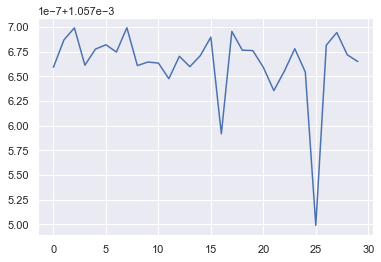

In [52]:
plt.plot(avg_loss_list)

## 05_Reload saved model

In [153]:
model_load_path = gru_model_folder + "model_2_all/"
epoch = 30
    
reports_features_scaler = load_scaler(model_save_path + "feature_scaler.gz")
stock_features_scaler   = load_scaler(model_save_path + "stock_scaler.gz")
labels_scaler           = load_scaler(model_save_path + "labels_scaler.gz")

model_loaded = TrainNet()
model_loaded.load_state_dict(torch.load(os.path.join(model_load_path, "final.model")))
model_loaded.to(device)
model_loaded.eval()

TrainNet(
  (series_model): GRUNet(
    (gru): GRU(46, 128, num_layers=2, batch_first=True, dropout=0.2)
    (fc): Linear(in_features=128, out_features=46, bias=True)
    (relu): ReLU()
  )
  (features_model): Sequential(
    (0): Linear(in_features=60, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=60, bias=True)
    (3): ReLU()
  )
  (combine_model): Sequential(
    (0): Linear(in_features=106, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
    (3): ReLU()
  )
)

## 06_Evaluate

### Tools

In [204]:
def calc_rsme(df:pd.DataFrame):
    rmse = ((df.r_potential-df.prediction)**2).mean()**0.5
    return rmse

In [205]:
def calc_rsme(df:pd.DataFrame):
    rmse = ((df.r_potential-df.prediction)**2).mean()**0.5
    return rmse

In [206]:
def draw_scatter(df_arr:List[pd.DataFrame], labels: List[str]):
    number = len(df_arr)
    fig, ax = plt.subplots(1, number, figsize=(number * 7,5))

    if number > 1:
        for i in range(number):
            ax[i].plot(df_arr[i].r_potential, df_arr[i].prediction,'b.')

            ax[i].set_title(labels[i])
            
            ax[i].set_ylim(-1,5)
            ax[i].set_xlim(-1,10)
            

            ax[i].set(xlabel='Potential', ylabel='Prediction')
    else:
            ax.plot(df_arr[0].r_potential, df_arr[0].prediction,'b.')

            ax.set_title(labels[0])

            ax.set_ylim(-1,5)
            ax.set_xlim(-1,10)
            
            ax.set(xlabel='Potential', ylabel='Prediction')

In [217]:
def create_groups(df:pd.DataFrame) -> List[pd.DataFrame]:
    pred_all =     df
    pred_min_10 =  df[df.prediction >  0.1]
    pred_min_30 =  df[df.prediction >  0.3]
    pred_min_50 =  df[df.prediction >  0.5]
    pred_min_75 =  df[df.prediction >  0.75]
    pred_min_100 = df[df.prediction >  1.0]
    pred_min_150 = df[df.prediction >  1.5]

    data_sets = [pred_all, pred_min_10, pred_min_30, pred_min_50, pred_min_75, pred_min_100, pred_min_150]
    return data_sets

group_labels = ['all', 'above 10%', 'above 30%','above 50%','above 75%','above 100%','above 150%']

In [218]:
def draw_box(list_df:List[pd.DataFrame]):
    data = [x.r_potential.tolist() for x in list_df]

    fig, ax = plt.subplots(figsize=(20,7))
    ax.boxplot(data, showmeans=True)
    ax.set_ylim(-1,3)
    plt.xticks(np.arange(len(group_labels))+1, group_labels)
    plt.show()

### Prediction

In [199]:
def predict_group(pd_group):
    
    nr_of_report_features               = len(features_reports)
    
    arr_of_arr_of_series_features = pd_group.features.to_numpy()
    series = np.concatenate(arr_of_arr_of_series_features) \
                              .reshape(arr_of_arr_of_series_features.shape[0], lookback_size, nr_of_report_features)

    table_features = pd_group[tabular_features].to_numpy()
    table_features = stock_features_scaler.transform(table_features)
    
    series_tensor = torch.from_numpy(series)
    table_features_tensor = torch.from_numpy(table_features)
    
    model_loaded.init_hidden(pd_group.shape[0])
    
    out_tensor = model_loaded(series_tensor.to(device).float(), table_features_tensor.to(device).float())
    out = labels_scaler.inverse_transform(out_tensor.cpu().detach().numpy()).reshape(-1)
    
    pd_group['prediction'] = out.tolist()

In [202]:
for group in test_pd_list:
    predict_group(group)

In [211]:
df_predicted_pd = pd.concat(test_pd_list)
df_predicted_pd['close_year'] = pd.DatetimeIndex(df_predicted_pd['Date']).year

In [212]:
calc_rsme(df_predicted_pd)

0.8996597742432426

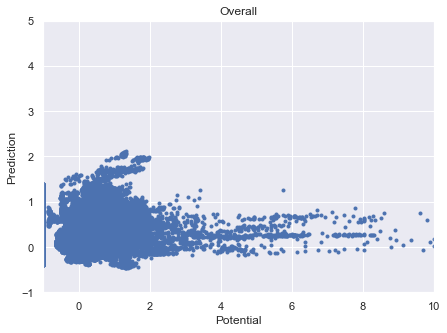

In [213]:
draw_scatter([df_predicted_pd],['Overall'])

### by Year All

In [214]:
df_2018 = df_predicted_pd[(df_predicted_pd.close_year == 2018)]
df_2019 = df_predicted_pd[(df_predicted_pd.close_year == 2019)]
df_2020 = df_predicted_pd[(df_predicted_pd.close_year == 2020)]

In [215]:
print("2018 Model Performance RMSE: %f" % calc_rsme(df_2018))
print("2019 Model Performance RMSE: %f" % calc_rsme(df_2019))
print("2020 Model Performance RMSE: %f" % calc_rsme(df_2020))

2018 Model Performance RMSE: 0.320320
2019 Model Performance RMSE: 0.986406
2020 Model Performance RMSE: 1.130474


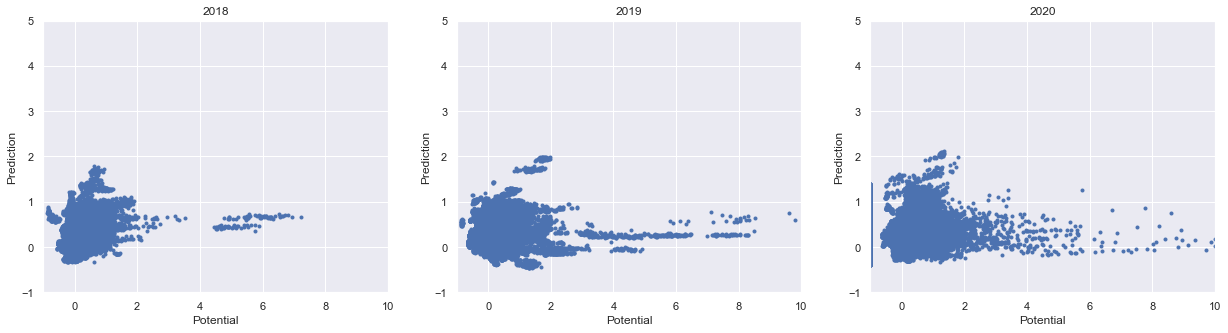

In [216]:
draw_scatter([df_2018, df_2019,df_2020],['2018','2019','2020'])

In [220]:
groups_top500_all = create_groups(df_predicted_pd)
groups_top500_2018 = create_groups(df_2018)
groups_top500_2019 = create_groups(df_2019)
groups_top500_2020 = create_groups(df_2020)

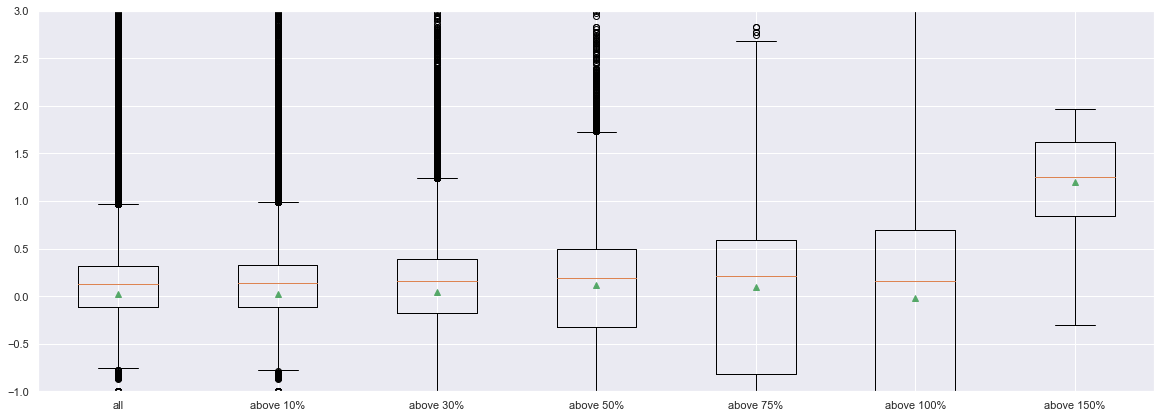

In [221]:
draw_box(groups_top500_all)

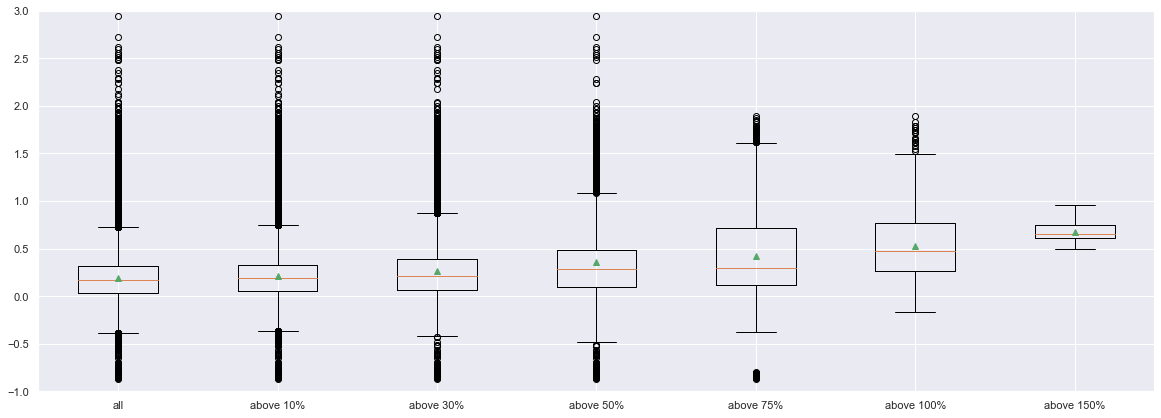

In [222]:
draw_box(groups_top500_2018)

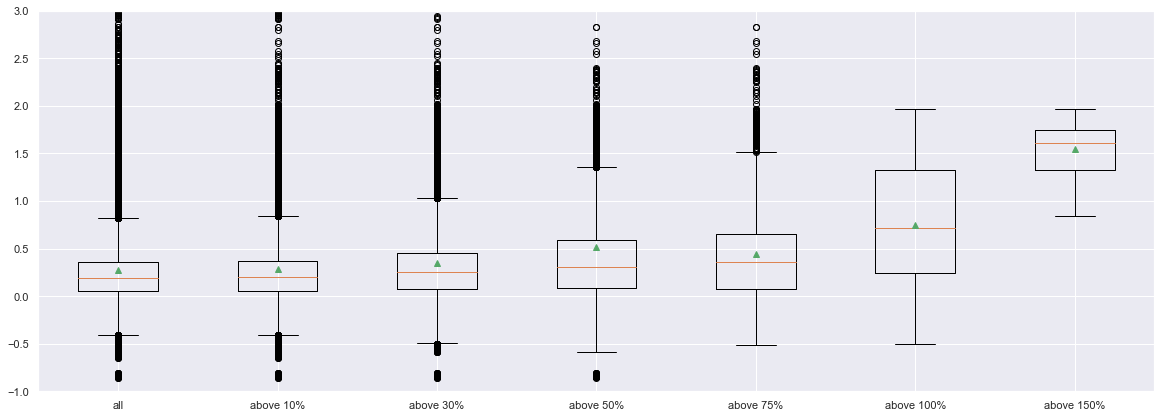

In [223]:
draw_box(groups_top500_2019)

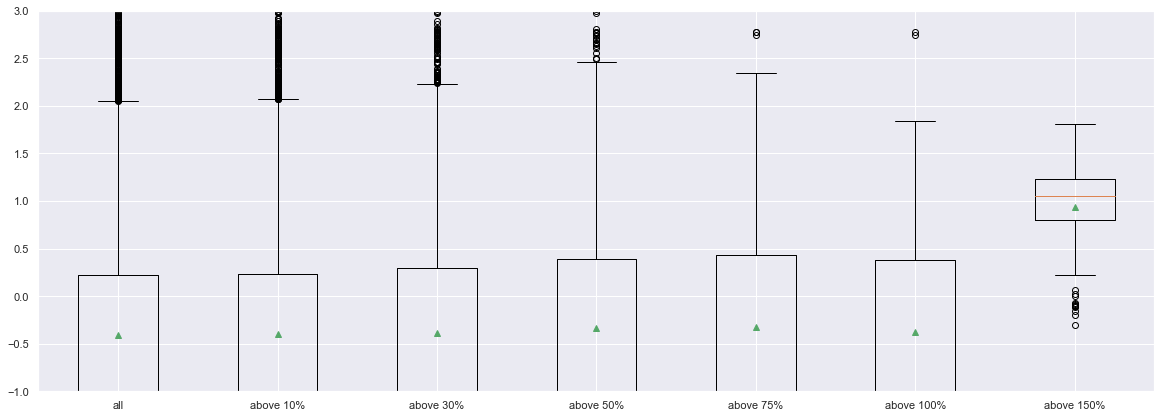

In [224]:
draw_box(groups_top500_2020)

## XX_Trials

In [161]:
test_model = model_loaded

train_s_x = torch.from_numpy(train_series_x[:2])
train_f_x = torch.from_numpy(train_features_x[:2])

print(train_s_x.shape, " ", train_f_x.shape)

test_model.init_hidden(2)

out2 = test_model(train_s_x.to(device).float(), train_f_x.to(device).float())
print(out2)
labels_scaler.inverse_transform(out2.cpu().detach().numpy()).reshape(-1)

torch.Size([2, 8, 46])   torch.Size([2, 60])
tensor([[0.0248],
        [0.0246]], device='cuda:0', grad_fn=<ReluBackward0>)


array([-0.00965667, -0.01824961], dtype=float32)

In [41]:
aapl_df = reports_df[reports_df.ticker == 'AAPL']
print(aapl_df.shape)
msft_df = reports_df[reports_df.ticker == 'MSFT']
print(msft_df.shape)
a_df = reports_df[reports_df.ticker == 'A']
print(a_df.shape)


(34, 85)
(34, 85)
(35, 85)
(0, 85)
(0, 85)


In [39]:
avgo_df.cik

Series([], Name: cik, dtype: int64)

In [35]:
seq_col = create_sequence_series(avgo_df)
merge_report_data_with_sequence_series(avgo_df, seq_col)

,filed,c_NetIncomeLoss,c_PaymentsOfDividendsTotal,Assets,Liabilities,gr_netincome_p,features
i_date,,,,,,,
2013-12-20,2013-12-20,5.520000e+08,198000000.0,3.415000e+09,5.290000e+08,-0.019538,"[[0.9237123131752014, 0.6167591214179993, 0.43..."
2014-03-13,2014-03-13,1.340000e+08,62000000.0,3.472000e+09,4.800000e+08,0.072000,"[[0.9213085770606995, 0.5973140001296997, 0.43..."
2014-06-10,2014-06-10,1.580000e+08,130000000.0,3.671000e+09,5.170000e+08,0.398230,"[[0.9278937578201294, 0.6536733508110046, 0.43..."
2014-09-12,2014-09-12,-1.640000e+08,203000000.0,1.026200e+10,7.164000e+09,-0.750000,"[[0.9317957758903503, 0.6922041773796082, 0.43..."
2014-12-29,2014-12-29,2.630000e+08,284000000.0,1.049100e+10,7.248000e+09,-0.523551,"[[0.9460984468460083, 0.8811360597610474, 0.42..."
2015-03-11,2015-03-11,3.510000e+08,89000000.0,1.069700e+10,7.069000e+09,0.750000,"[[0.9394939541816711, 0.7827935814857483, 0.43..."
2015-06-10,2015-06-10,3.440000e+08,188000000.0,1.053200e+10,6.471000e+09,0.750000,"[[0.9228112697601318, 0.6093282103538513, 0.43..."
2015-09-10,2015-09-10,2.400000e+08,292000000.0,9.988000e+09,5.707000e+09,-0.000000,"[[0.9224422574043274, 0.6063345670700073, 0.43..."
2015-12-17,2015-12-17,1.364000e+09,408000000.0,1.059200e+10,5.878000e+09,0.750000,"[[0.9347319602966309, 0.724234938621521, 0.430..."


In [107]:
np_df_features = reports_features_scaler.transform(reports_df[features_reports]).astype(np.float32)
print(np_df_features.dtype)
np_df_features.shape

float32


(34, 46)

In [79]:
lookback_size = 8
number_of_features = len(features_reports)
number_of_rows = len(np_df_features)

number_of_sequences = number_of_rows - lookback + 1

inputs = np.zeros((number_of_sequences, lookback, number_of_features))
print(inputs.shape)

(27, 8, 46)


In [96]:
for i in range(0, number_of_sequences):
    inputs[i] = np_df_features[i : i + lookback]
    
print (inputs.shape)

(27, 8, 46)


In [98]:
flat_input = inputs.reshape(-1, lookback_size * number_of_features)
flat_input.shape

(27, 368)

In [102]:
features_col = pd.Series(flat_input.tolist(), name='features').apply(lambda field: np.array(field).reshape(lookback, number_of_features))
features_col.shape

(27,)

In [103]:
date_col = reports_df.filed[lookback - 1:].reset_index(drop=True)
date_col.shape

(27,)

In [104]:
 df_combined = pd.concat([date_col, features_col], axis=1)

,filed,features
0,2014-01-28,"[[0.7868078389231806, 0.6630857047421554, 0.01..."
1,2014-04-24,"[[0.776629286748127, 0.6496306048392506, 0.006..."
2,2014-07-23,"[[0.7078445773271538, 0.5637078809160074, 0.01..."
3,2014-10-27,"[[0.7519515180156731, 0.6178265461170032, 0.03..."
4,2015-01-28,"[[0.9394095609049016, 0.8921025625874786, 0.0,..."
5,2015-04-28,"[[0.9999999999999999, 1.0000000000000002, 0.06..."
6,2015-07-22,"[[0.8640773461987664, 0.7722151793702814, 0.08..."
7,2015-10-28,"[[0.706357307915412, 0.5619409510885764, 0.101..."
8,2016-01-27,"[[0.8280166003209201, 0.7196892650544637, 0.09..."
9,2016-04-27,"[[0.6832097720805139, 0.5349050497826269, 0.13..."


In [88]:
np_df_features

array([[0.78680784, 0.6630857 , 0.0119307 , ..., 1.        , 0.        ,
        0.        ],
       [0.77662929, 0.6496306 , 0.00691177, ..., 0.        , 1.        ,
        0.        ],
       [0.70784458, 0.56370788, 0.01764061, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.79937715, 0.67998255, 0.80159741, ..., 0.        , 0.        ,
        0.        ],
       [0.70795353, 0.56383747, 0.89674084, ..., 1.        , 0.        ,
        0.        ],
       [0.68206885, 0.53359463, 1.        , ..., 0.        , 1.        ,
        0.        ]])

In [83]:
new_df = pd.DataFrame(np_df_features)
new_df.shape

(34, 46)

In [90]:
filed_col = reports_df.filed.reset_index(drop=True)
print(filed_col.shape)
result = pd.concat([filed_col, new_df], axis=1, ignore_index=True)
result

(34,)


,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,2012-04-25,0.786808,0.663086,0.011931,0.035571,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,0.0,0.353778,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
1,2012-07-25,0.776629,0.649631,0.006912,0.020817,0.565625,0.650950,0.603353,0.000000,0.997016,...,1.0,0.0,0.353778,0.0,0.000000,0.0,0.0,0.0,1.0,0.0
2,2012-10-31,0.707845,0.563708,0.017641,0.051999,0.666490,0.777428,0.733998,1.000000,0.968144,...,1.0,0.0,0.353778,0.0,0.000000,1.0,0.0,0.0,0.0,0.0
3,2013-01-24,0.751952,0.617827,0.034704,0.098949,0.167814,0.568224,0.496380,0.622115,0.856895,...,1.0,0.0,0.353778,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
4,2013-04-24,0.939410,0.892103,0.000000,0.000000,0.059409,0.412637,0.310148,1.000000,0.859870,...,0.0,0.0,0.538709,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
5,2013-07-24,1.000000,1.000000,0.061922,0.167797,0.000000,0.258043,0.100323,1.000000,0.849345,...,0.0,0.0,0.418530,0.0,0.000000,0.0,0.0,0.0,1.0,0.0
6,2013-10-30,0.864077,0.772215,0.080637,0.211303,0.071725,0.405263,0.290171,1.000000,0.777455,...,1.0,0.0,0.427019,0.0,0.000000,1.0,0.0,0.0,0.0,0.0
7,2014-01-28,0.706357,0.561941,0.101279,0.256077,0.100912,0.498011,0.381372,0.000000,0.751768,...,1.0,0.0,0.311000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
8,2014-04-24,0.828017,0.719689,0.093698,0.240003,0.232948,0.467587,0.354666,0.848017,0.446036,...,1.0,0.0,0.364034,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
9,2014-07-23,0.683210,0.534905,0.136333,0.325314,0.237416,0.337811,0.203833,0.000000,0.656839,...,1.0,0.0,0.435719,0.0,0.000000,0.0,0.0,0.0,1.0,0.0


In [85]:
# funktioniert
filed_col = reports_df.filed.reset_index().drop(['i_date'], axis = 1).filed
print(filed_col.shape)
result = pd.concat([filed_col, new_df], axis=1, ignore_index=True)
result

(34,)


,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,2012-04-25,0.786808,0.663086,0.011931,0.035571,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.0,0.0,0.353778,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
1,2012-07-25,0.776629,0.649631,0.006912,0.020817,0.565625,0.650950,0.603353,0.000000,0.997016,...,1.0,0.0,0.353778,0.0,0.000000,0.0,0.0,0.0,1.0,0.0
2,2012-10-31,0.707845,0.563708,0.017641,0.051999,0.666490,0.777428,0.733998,1.000000,0.968144,...,1.0,0.0,0.353778,0.0,0.000000,1.0,0.0,0.0,0.0,0.0
3,2013-01-24,0.751952,0.617827,0.034704,0.098949,0.167814,0.568224,0.496380,0.622115,0.856895,...,1.0,0.0,0.353778,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
4,2013-04-24,0.939410,0.892103,0.000000,0.000000,0.059409,0.412637,0.310148,1.000000,0.859870,...,0.0,0.0,0.538709,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
5,2013-07-24,1.000000,1.000000,0.061922,0.167797,0.000000,0.258043,0.100323,1.000000,0.849345,...,0.0,0.0,0.418530,0.0,0.000000,0.0,0.0,0.0,1.0,0.0
6,2013-10-30,0.864077,0.772215,0.080637,0.211303,0.071725,0.405263,0.290171,1.000000,0.777455,...,1.0,0.0,0.427019,0.0,0.000000,1.0,0.0,0.0,0.0,0.0
7,2014-01-28,0.706357,0.561941,0.101279,0.256077,0.100912,0.498011,0.381372,0.000000,0.751768,...,1.0,0.0,0.311000,0.0,0.000000,0.0,1.0,0.0,0.0,0.0
8,2014-04-24,0.828017,0.719689,0.093698,0.240003,0.232948,0.467587,0.354666,0.848017,0.446036,...,1.0,0.0,0.364034,0.0,0.000000,0.0,0.0,1.0,0.0,0.0
9,2014-07-23,0.683210,0.534905,0.136333,0.325314,0.237416,0.337811,0.203833,0.000000,0.656839,...,1.0,0.0,0.435719,0.0,0.000000,0.0,0.0,0.0,1.0,0.0


In [71]:
df1 = pd.DataFrame(
     {
         "A": ["A0", "A1", "A2", "A3"],
         "B": ["B0", "B1", "B2", "B3"],
         "C": ["C0", "C1", "C2", "C3"],
         "D": ["D0", "D1", "D2", "D3"],
     },
     index=[0, 1, 2, 3],
 )

s1 = pd.Series(["X0", "X1", "X2", "X3"], name="X")

result = pd.concat([df1, s1], axis=1)

In [72]:
result

,A,B,C,D,X
0,A0,B0,C0,D0,X0
1,A1,B1,C1,D1,X1
2,A2,B2,C2,D2,X2
3,A3,B3,C3,D3,X3


### reshaping

In [55]:
input_np = np.arange(1, 33).reshape(8,4)
data_rows = input_np.shape[0]
input_np

array([[ 1,  2,  3,  4],
       [ 5,  6,  7,  8],
       [ 9, 10, 11, 12],
       [13, 14, 15, 16],
       [17, 18, 19, 20],
       [21, 22, 23, 24],
       [25, 26, 27, 28],
       [29, 30, 31, 32]])

In [57]:
test_lookback = 3
nr_of_sequences = data_rows - test_lookback + 1

test_inputs = np.zeros((nr_of_sequences, test_lookback, 4))
print(test_inputs.shape)

(6, 3, 4)


In [52]:
#for i in range(lookback, len(np_df_features)):
#    inputs[i-lookback] = np_df_features[i-lookback:i]

In [63]:
for i in range(0, nr_of_sequences):
    test_inputs[i] = input_np[i : i + test_lookback]

In [64]:
print(test_inputs.shape)
test_inputs

(6, 3, 4)


array([[[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.]],

       [[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.]],

       [[ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]],

       [[13., 14., 15., 16.],
        [17., 18., 19., 20.],
        [21., 22., 23., 24.]],

       [[17., 18., 19., 20.],
        [21., 22., 23., 24.],
        [25., 26., 27., 28.]],

       [[21., 22., 23., 24.],
        [25., 26., 27., 28.],
        [29., 30., 31., 32.]]])

In [65]:
test_inputs = test_inputs.reshape(-1, test_lookback, 4)
print (test_inputs.shape)
test_inputs

(6, 3, 4)


array([[[ 1.,  2.,  3.,  4.],
        [ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.]],

       [[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.]],

       [[ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]],

       [[13., 14., 15., 16.],
        [17., 18., 19., 20.],
        [21., 22., 23., 24.]],

       [[17., 18., 19., 20.],
        [21., 22., 23., 24.],
        [25., 26., 27., 28.]],

       [[21., 22., 23., 24.],
        [25., 26., 27., 28.],
        [29., 30., 31., 32.]]])

In [68]:
flat = test_inputs.reshape(-1, test_lookback * 4)
flat

array([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.],
       [ 5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16.],
       [ 9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.],
       [13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24.],
       [17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.],
       [21., 22., 23., 24., 25., 26., 27., 28., 29., 30., 31., 32.]])

In [71]:
flat.tolist()

[[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0],
 [5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0],
 [9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0],
 [13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0],
 [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0],
 [21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0]]

In [72]:
pd.Series(flat.tolist())

0    [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, ...
1    [5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13...
2    [9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0...
3    [13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20....
4    [17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24....
5    [21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28....
dtype: object

In [94]:
pd.Series(flat.tolist()).apply(lambda field: np.array(field).reshape(test_lookback, 4))

0    [[1.0, 2.0, 3.0, 4.0], [5.0, 6.0, 7.0, 8.0], [...
1    [[5.0, 6.0, 7.0, 8.0], [9.0, 10.0, 11.0, 12.0]...
2    [[9.0, 10.0, 11.0, 12.0], [13.0, 14.0, 15.0, 1...
3    [[13.0, 14.0, 15.0, 16.0], [17.0, 18.0, 19.0, ...
4    [[17.0, 18.0, 19.0, 20.0], [21.0, 22.0, 23.0, ...
5    [[21.0, 22.0, 23.0, 24.0], [25.0, 26.0, 27.0, ...
dtype: object